# Learning Volatility Surface Dynamics with NSPDE.

In this notebook we train the NSPDE model by minimising an expected signature kernel score to learn volatility surface dynamics.

### Imports

In [1]:
import torch

from torch.optim.lr_scheduler import ReduceLROnPlateau
import os
import scipy
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display
from src.gan.discriminators_spde import SigKerMMDDiscriminator, ExpectedSigKerScoreDiscriminator
from src.gan.generators_spde import Generator
from src.gan.output_functions import plot_loss
from src.gan.base import stopping_criterion
from statsmodels.tsa.stattools import acf
from src.evaluation import generate_ks_results_nspde
from src.utils.helper_functions.global_helper_functions import get_project_root

In [2]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'

if not is_cuda:
    print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

## 1. Get data

In [3]:
data = torch.load(get_project_root().as_posix() + '/data/rBergomi_vol_surfaces.pt')
method = "slice"

In [4]:
if method == "slice":
    # For now, just take ATM vol slice
    data = data[..., 5].unsqueeze(-1)
elif method == "stack":
    T_cut = 2
    K_cut = 3
    data = data[:, :, T_cut:-T_cut, K_cut:-K_cut]
    N, t, T, K = data.shape
    data = data.reshape(N, t, T*K, 1)

In [5]:
N, dim_t, dim_x, output_dim = data.shape

In [6]:
gridT = torch.linspace(0, 1, dim_t).repeat(dim_x, 1)
gridX = torch.linspace(0, 1, dim_x).unsqueeze(-1).repeat(1, dim_t)

grid = torch.stack([gridX, gridT], dim=-1).to(device)

## 1.1 Pre-transformation of data

In [7]:
def apply_boxcox(data_4d):
    """
    Apply Box-Cox transformation to a 4D dataset.
    
    Parameters:
    - data_4d: 4D NumPy array with shape (N, n_t, n_x, 1).
    
    Returns:
    - transformed_data: Box-Cox transformed data.
    - lambdas: Lambda values used for the transformation.
    """
    N, n_t, n_x, _ = data_4d.shape
    min_ = np.abs(data_4d.min())
    adj = min_ + 1e-6
    data_reshaped = data_4d.reshape(-1, n_x) + adj # Flatten the first two dimensions
    
    transformed_data_reshaped = np.zeros_like(data_reshaped)
    lambdas = np.zeros(n_x)
    
    for i in tqdm(range(n_x)):
        # Ensure all data is positive
        transformed_data_reshaped[:, i], lambdas[i] = boxcox(data_reshaped[:, i])
    
    # Reshape back to original 4D shape
    transformed_data = transformed_data_reshaped.reshape(N, n_t, n_x, 1)
    
    return transformed_data, lambdas, adj


def apply_inverse_boxcox(transformed_data, lambdas, adj):
    """
    Apply the inverse Box-Cox transformation to the transformed data.
    
    Parameters:
    - transformed_data: Box-Cox transformed 4D data array.
    - lambdas: Lambda values used for the Box-Cox transformation.
    
    Returns:
    - inverse_transformed_data: Data reverted to its original form.
    """
    N, n_t, n_x, _ = transformed_data.shape
    transformed_data_reshaped = transformed_data.reshape(-1, n_x)
    
    inverse_transformed_data_reshaped = np.zeros_like(transformed_data_reshaped)
    
    for i in tqdm(range(n_x)):
        lambda_val = lambdas[i]
        if lambda_val == 0:
            inverse_transformed_data_reshaped[:, i] = np.exp(transformed_data_reshaped[:, i])
        else:
            inverse_transformed_data_reshaped[:, i] = (lambda_val * transformed_data_reshaped[:, i] + 1) ** (1 / lambda_val)
    
    # Reshape back to the original 4D shape
    inverse_transformed_data = inverse_transformed_data_reshaped.reshape(N, n_t, n_x, 1)
    
    return inverse_transformed_data - adj

In [8]:
# Try Box-Cox
do_box_cox = False

if do_box_cox:
    with torch.no_grad():
        data_np = data.cpu().numpy()
        transformed_data, lambdas, adj = apply_boxcox(data_np)
        
        transformed_data_tensor = torch.from_numpy(transformed_data).to(device)
        
        # Idea is that distribution in each marginal is not Gaussian enough for the generator
        # Try to "Gaussianify" the input surfaces
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        n_plots = 8192
        t = 0
        ax1.hist(data[:n_plots, t, 0, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
        ax2.hist(data[:n_plots, t, 5, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
        ax3.hist(data[:n_plots, t, -1, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
        ax1.hist(transformed_data_tensor[:n_plots, t, 0, 0].cpu(), bins=64, density=True, alpha=0.5, color="tomato")
        ax2.hist(transformed_data_tensor[:n_plots, t, 5, 0].cpu(), bins=64, density=True, alpha=0.5, color="tomato")
        ax3.hist(transformed_data_tensor[:n_plots, t, -1, 0].cpu(), bins=64, density=True, alpha=0.5, color="tomato")

In [9]:
# Test the inverse function
if do_box_cox:
    re_transformed_data = apply_inverse_boxcox(transformed_data, lambdas, adj)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.hist(data[:n_plots, t, 0, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
    ax2.hist(data[:n_plots, t, 5, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
    ax3.hist(data[:n_plots, t, -1, 0].cpu(), bins=64, density=True, alpha=0.5, color="dodgerblue")
    ax1.hist(re_transformed_data[:n_plots, t, 0, 0], bins=64, density=True, alpha=0.5, color="tomato")
    ax2.hist(re_transformed_data[:n_plots, t, 5, 0], bins=64, density=True, alpha=0.5, color="tomato")
    ax3.hist(re_transformed_data[:n_plots, t, -1, 0], bins=64, density=True, alpha=0.5, color="tomato")

## 2. Begin training

In this section we set the training parameters for the GAN. Each parameter is annotated.

In [202]:
# Generator arguments
dim                = 1
initial_noise_size = 1              # How many noise dimensions to sample at the start of the SDE.
noise_size         = 2              # How many dimensions the Wiener process motion has.
num_layers         = 1
hidden_size        = 16             # How big the hidden state of the generator NSPDE is.
noise_type         = "white"        # Noise type argument for torchspde
integration_method = "fixed_point"  # Integration method to solve the latent SPDE
fixed              = True           # Whether to fix the starting point or not
data_size          = data.shape[-1]
modes1             = dim_x          # Number of modes to perform convolution in the spatial dimension
modes2             = dim_t          # Number of modes to perform convolution in the temporal dimension
n_iter             = 10              # Number of iterations to solve the fixed point problem (if integration_method is "fixed_point")

# Discriminator args
dyadic_order   = 2                 # Mesh size of PDE solver used in loss function
kernel         = "rbf_sqr"          # Type of kernel to use in the discriminator
use_phi_kernel = False             # Whether we want to take averages of signature kernels 
n_scalings     = 3                 # Number of kernels to average
#sigma          = {"sigma": 1e-2}     # hyperparameters of the kernel
sigma = {'sigma1': 1e-2, 'sigma2': 1e-2}       
# sigma = {'sigma1': 10, 'sigma2': 10, 'n_freqs': 8}
adversarial   = False               # Whether to adversarially train the discriminator or not.
max_batch     = 32                  # Maximum batch size to pass through the discriminator.
loss_evals    = 1                   # Number of evaluations before doing gradient step

if not adversarial:
    # discriminator_type = "mmd"
    discriminator_type = "scoring"
else:
    discriminator_type = "mmd"

# Training hyperparameters
generator_lr     = 5e-05         # Generator initial learning rate
generator_mom    = 0.            # (Optional) momentum parameter for generator
discriminator_lr = 3e-03         # Discriminator initial learning rate
disriminator_mom = 0.            # (Optional) momentum parameter for discriminator
batch_size       = 64           # Batch size (set above in the data extraction)
steps            = 5000         # How many steps to train both generator and discriminator for.
gen_optim        = "Adam"        # Optimiser for generator

weight_decay     = 5e-04       # Weight decay.
disc_optim       = "Adam"        # Optimiser for discriminator

# Evaluation and plotting hyperparameters
steps_per_print  = int(steps/10)             # How often to print the loss.
update_freq      = int(steps/10)

In [203]:
if do_box_cox:
    dataloader = torch.utils.data.DataLoader(transformed_data_tensor, batch_size=batch_size, shuffle=True)
else:
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    
infinite_train_dataloader = (elem for it in iter(lambda: dataloader, None) for elem in it)

## 2.2 Init Generator

In [204]:
# create correlation function for the noise in input to the generator
import math
def my_smooth_corr(x, a, r = 2):
    my_eps=0.001
    j = 1.*torch.arange(1,x.shape[0]+1).to(x.device)
    j[-1] = 0.
    q = j**(-(2*r+1+my_eps)/2)
    q[-1]=0
    res = torch.sqrt(q)*torch.sqrt(2. / a) * torch.sin(j * math.pi * x / a)
    return res

if noise_type[0] == 'r':
    input_roughness = int(noise_type.split('_')[-1])
    noise_type = lambda x, a : my_smooth_corr(x, a, r = input_roughness)

# Initialise the generator
generator = Generator(
    dim=dim,
    data_size=output_dim, 
    initial_noise_size=initial_noise_size,
    noise_size=noise_size, 
    hidden_size=hidden_size, 
    num_layers=3,
    initial_point='given',
    noise_type=noise_type,
    integration_method=integration_method,
    modes1=modes1, 
    modes2=modes2,
    n_iter=n_iter,
).to(device)

## 2.3 Init Discriminator

In [205]:
# Initialise the discriminator
if discriminator_type.lower() == "scoring":
    discriminator = ExpectedSigKerScoreDiscriminator(
        kernel_type = kernel,
        dyadic_order = dyadic_order,
        sigma=sigma,
        path_dim = output_dim,
        adversarial=adversarial,
        max_batch=max_batch,
        use_phi_kernel = use_phi_kernel,
        n_scalings = n_scalings
    ).to(device)
else:
    discriminator = SigKerMMDDiscriminator(
        kernel_type=kernel, 
        dyadic_order=dyadic_order, 
        path_dim=output_dim, 
        sigma=sigma,
        adversarial=adversarial,
        max_batch=max_batch
    ).to(device)

## 3. Train the NSPDE

In [206]:
generator_optimiser = torch.optim.Adam(generator.parameters(), lr=generator_lr)#, weight_decay=weight_decay)

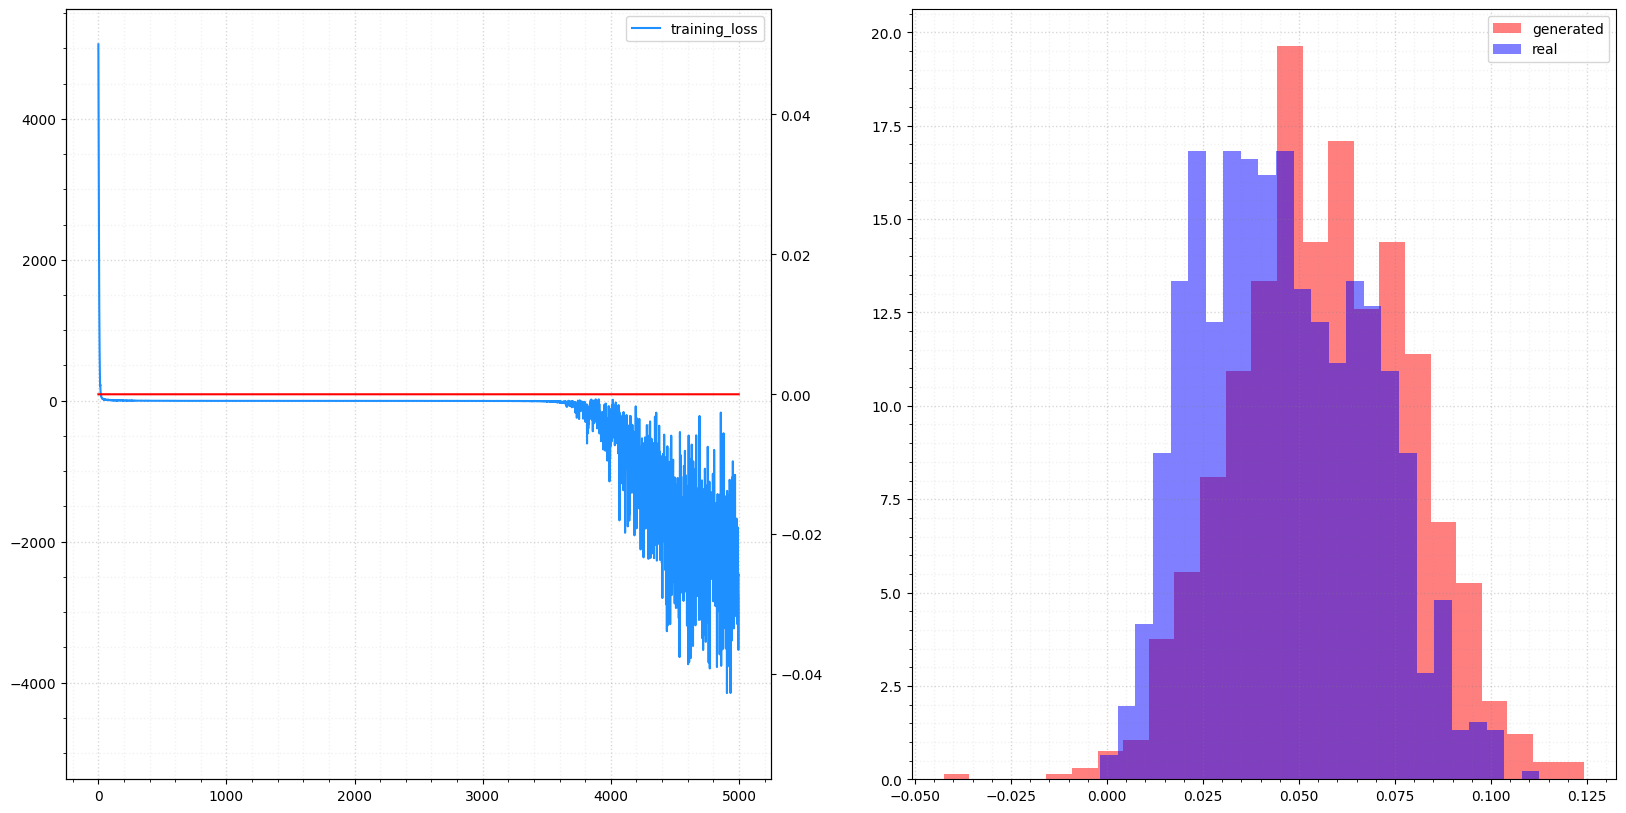

100%|██████████| 5000/5000 [1:49:02<00:00,  1.31s/it]


Step: 4999 Total loss (unaveraged): -2.00526e+03 K-S passed: 11.06%


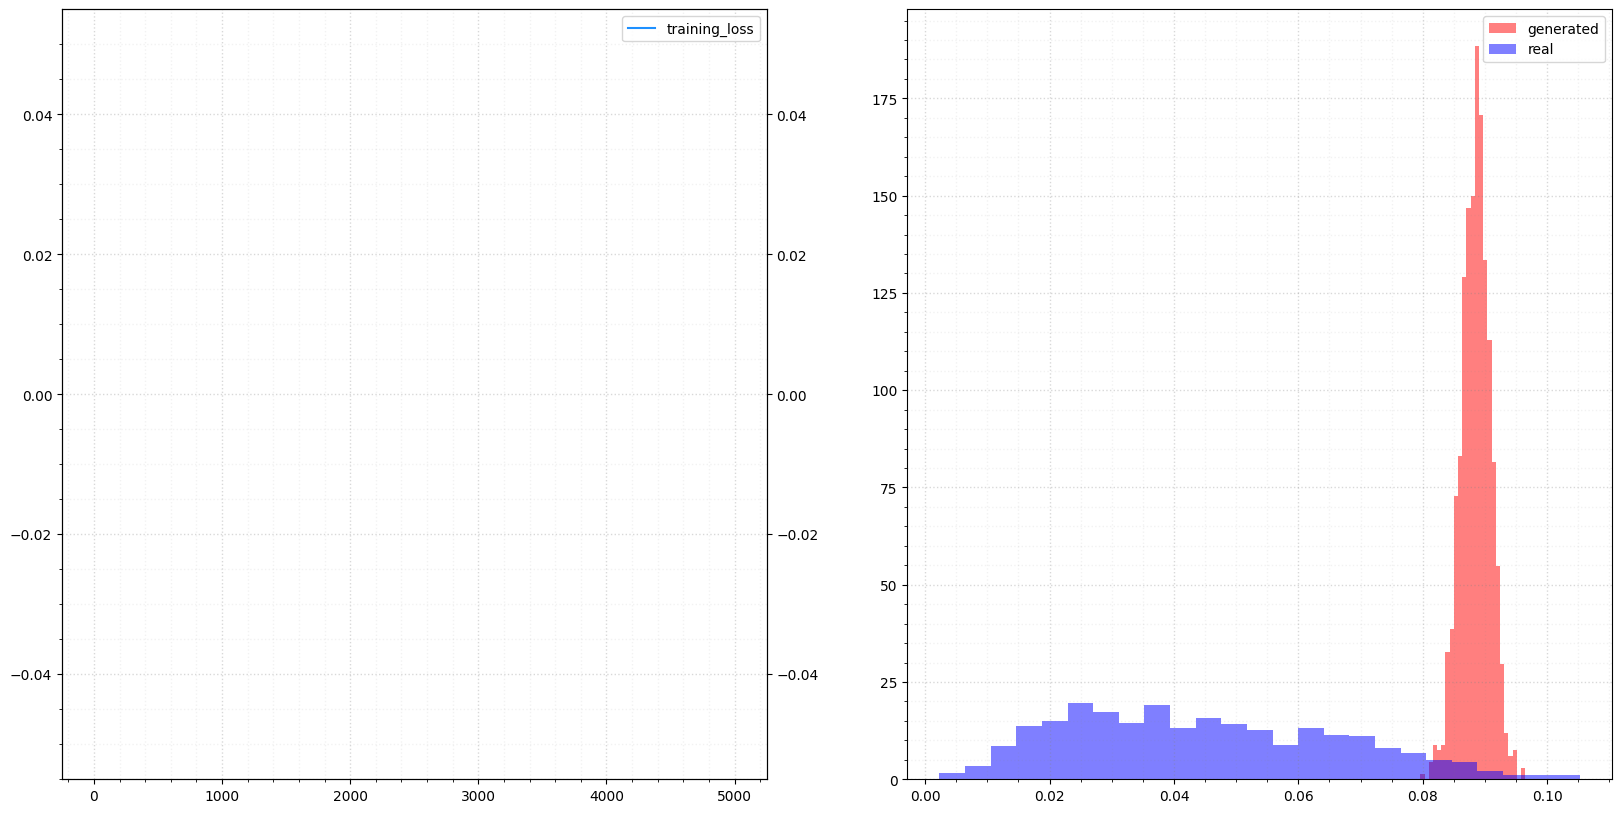

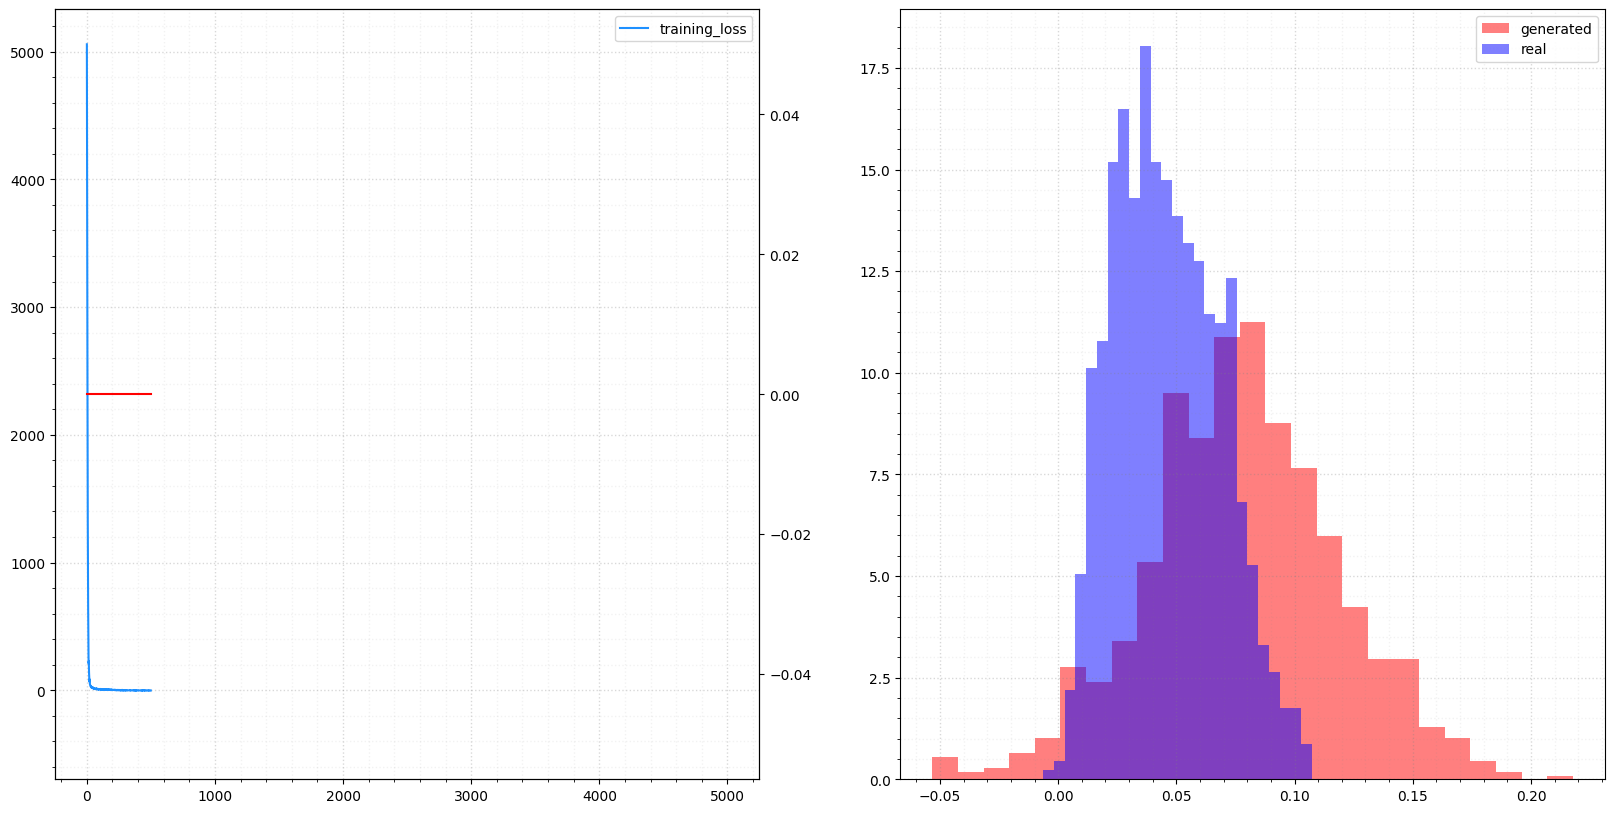

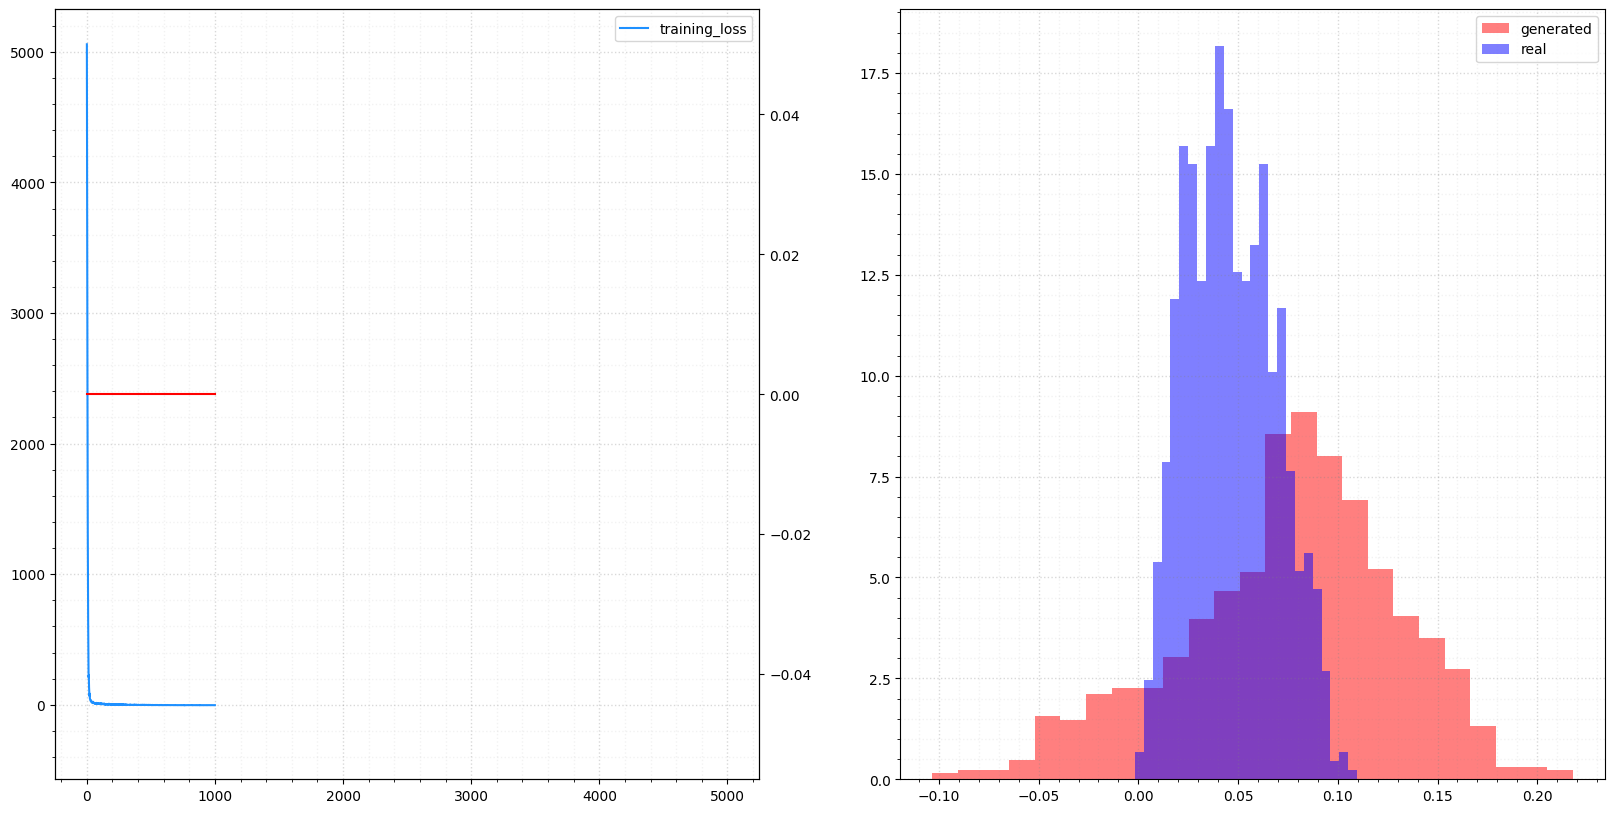

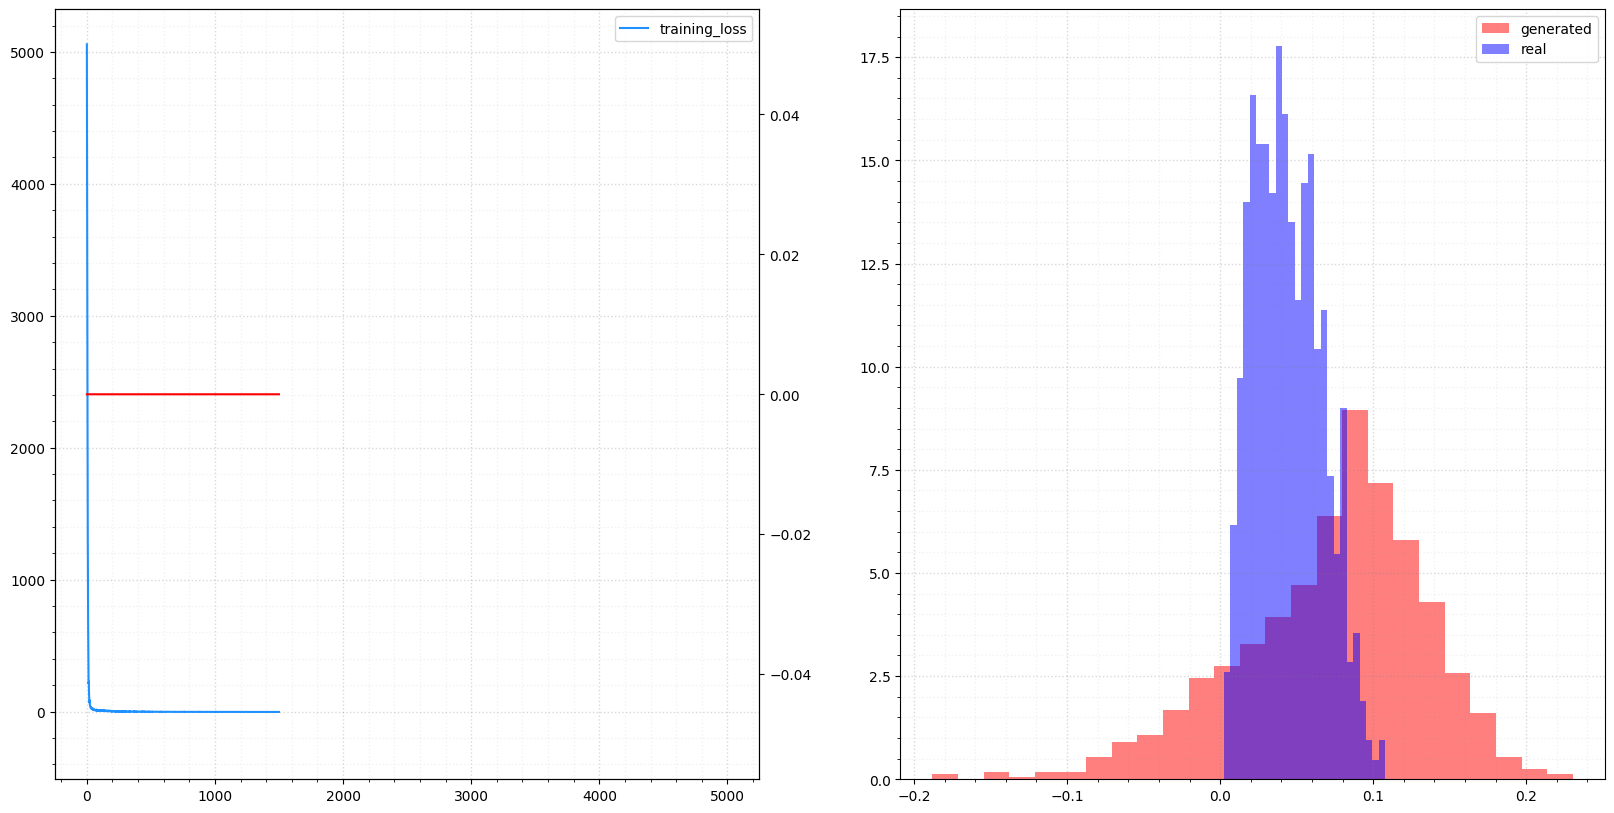

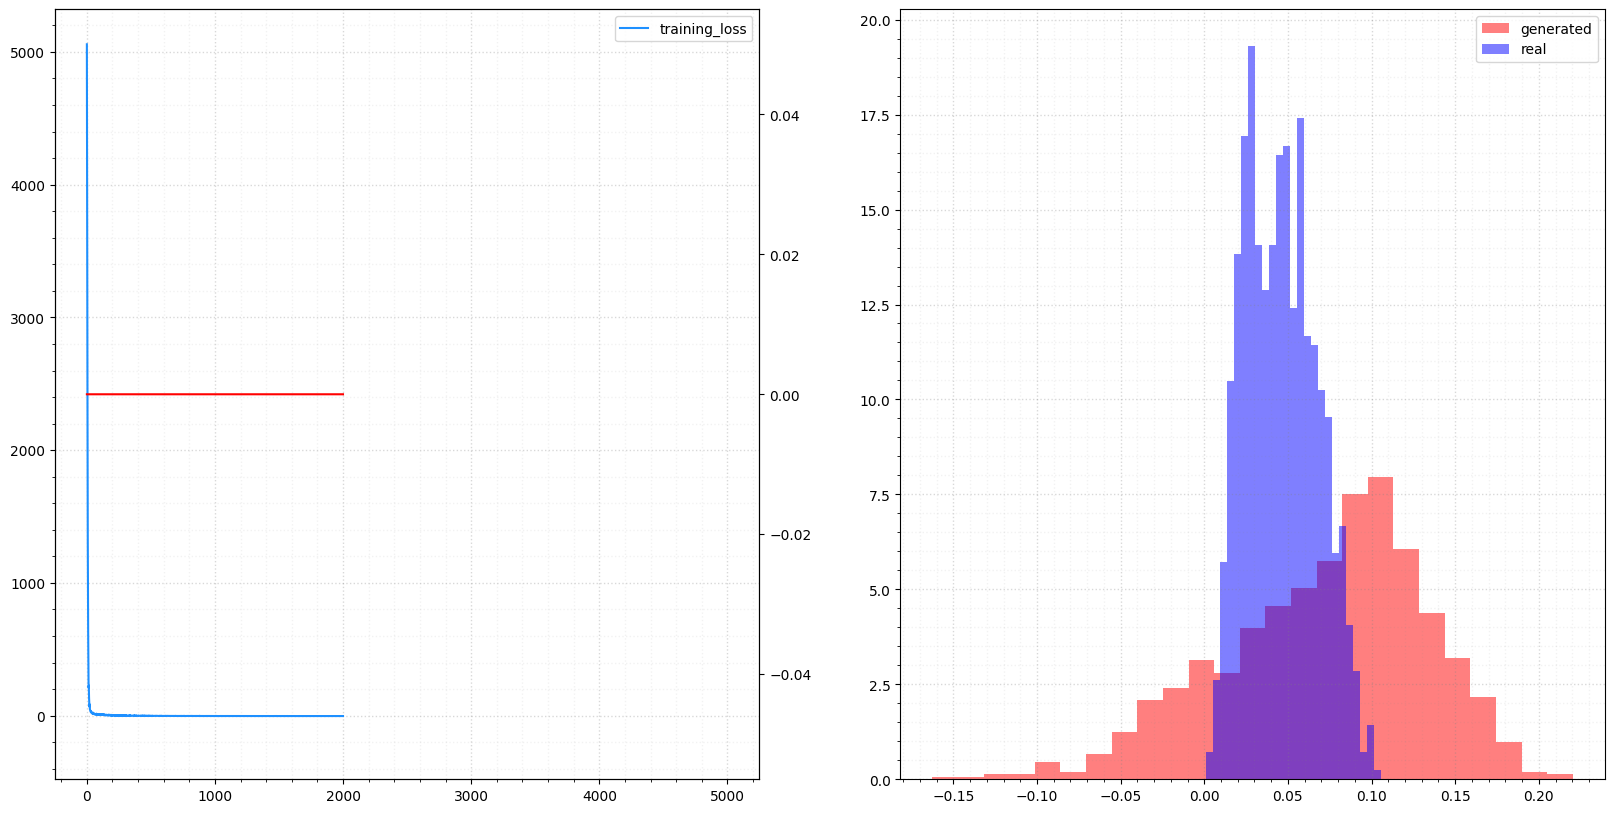

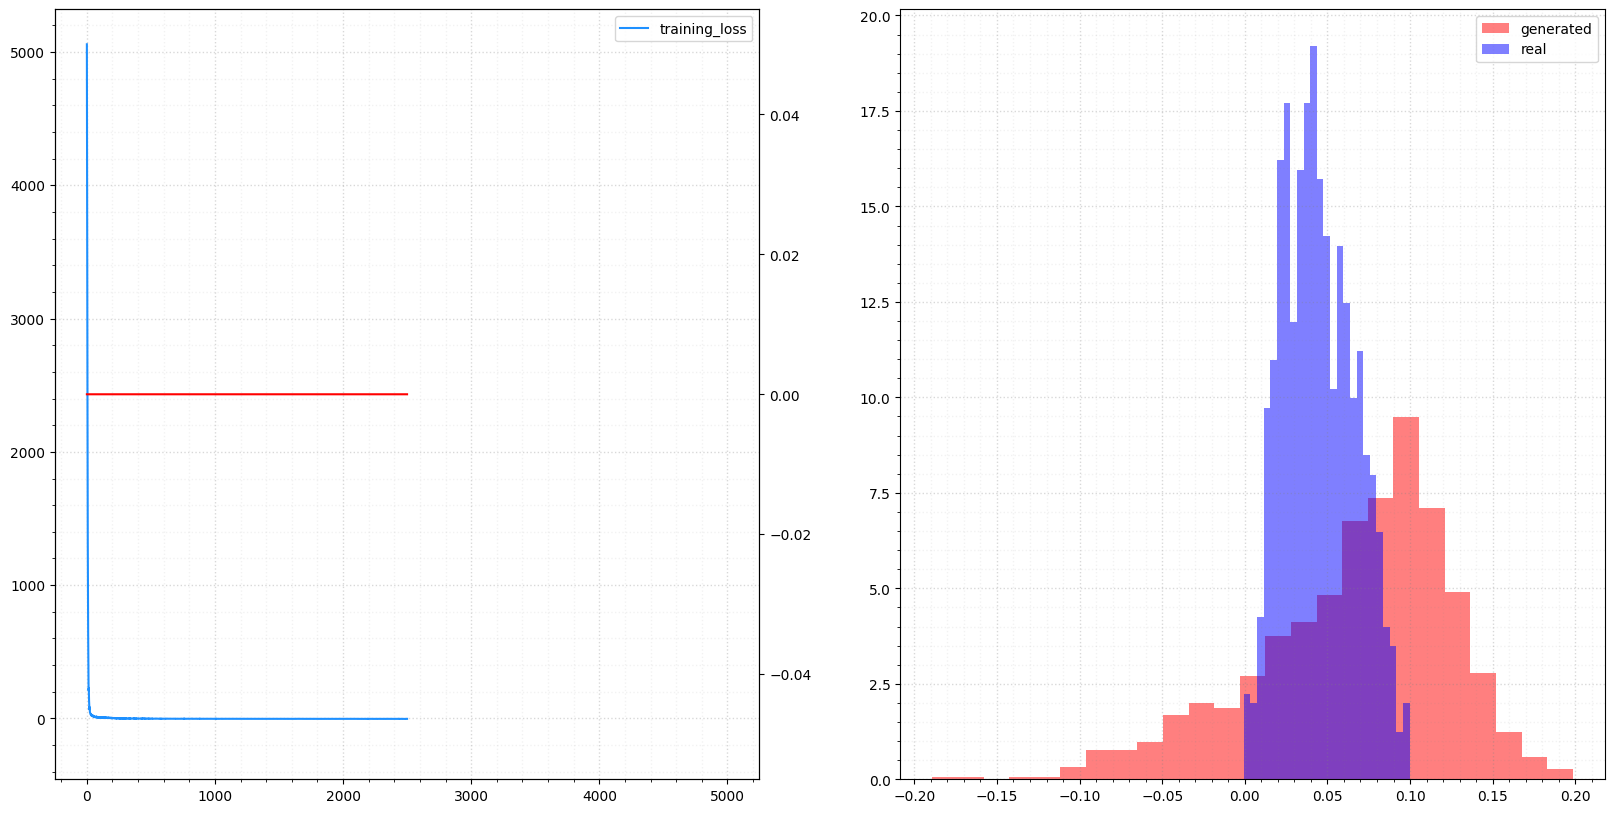

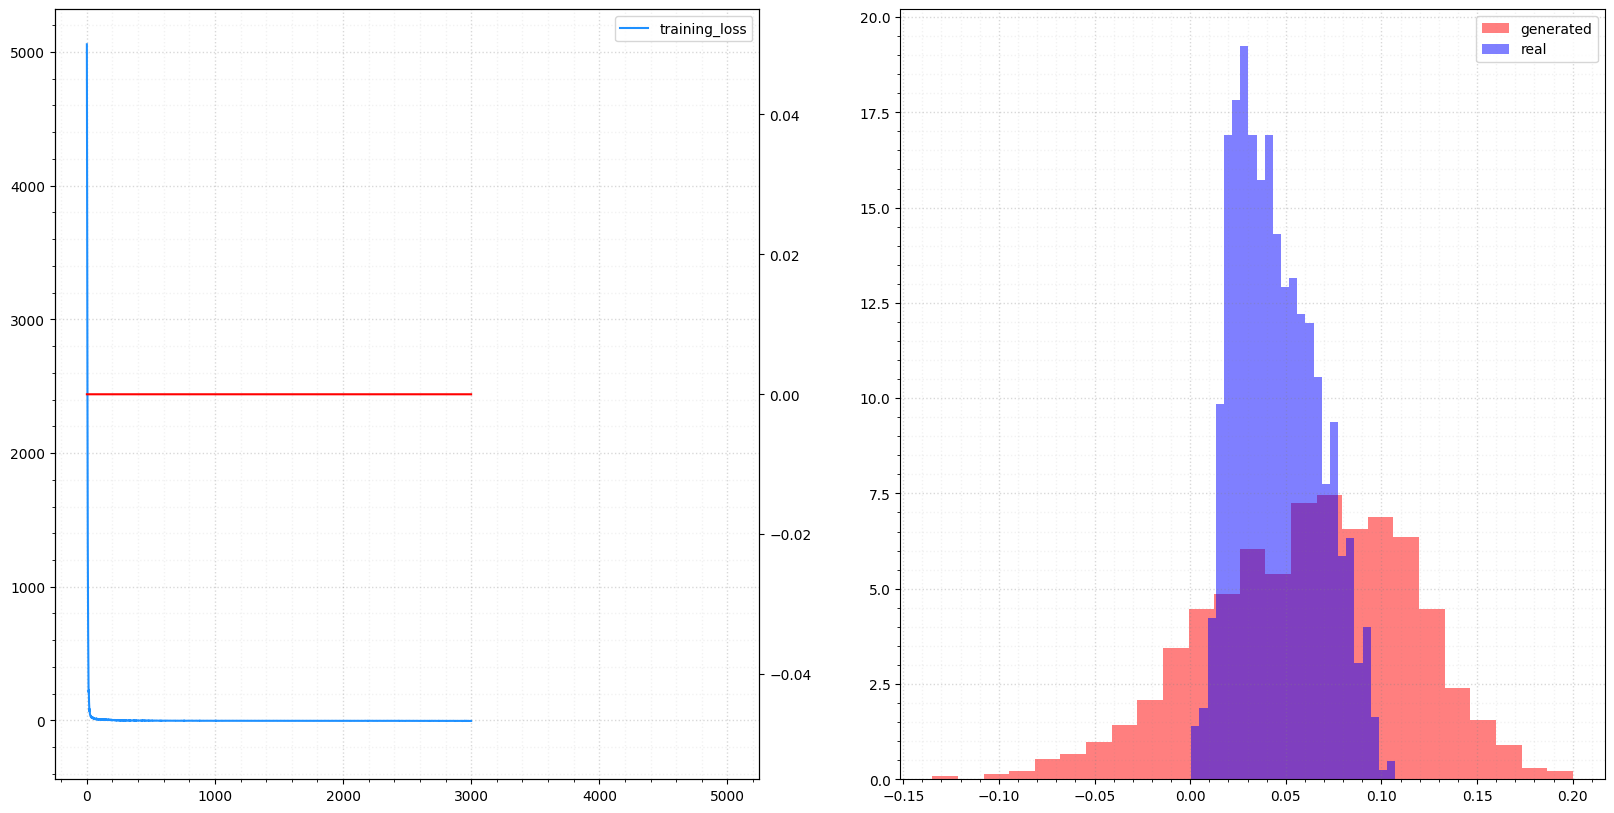

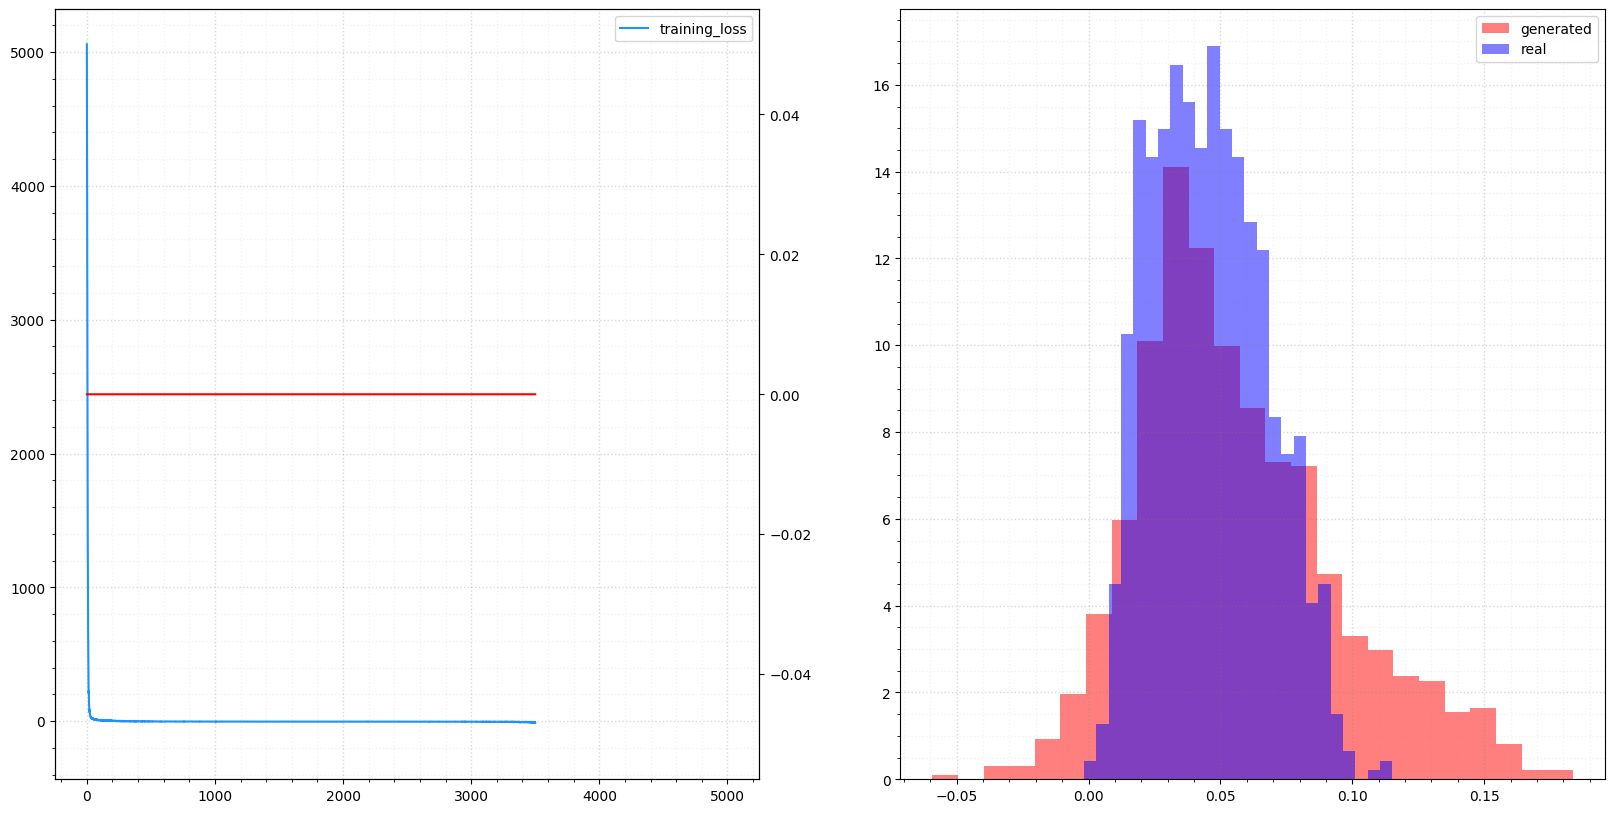

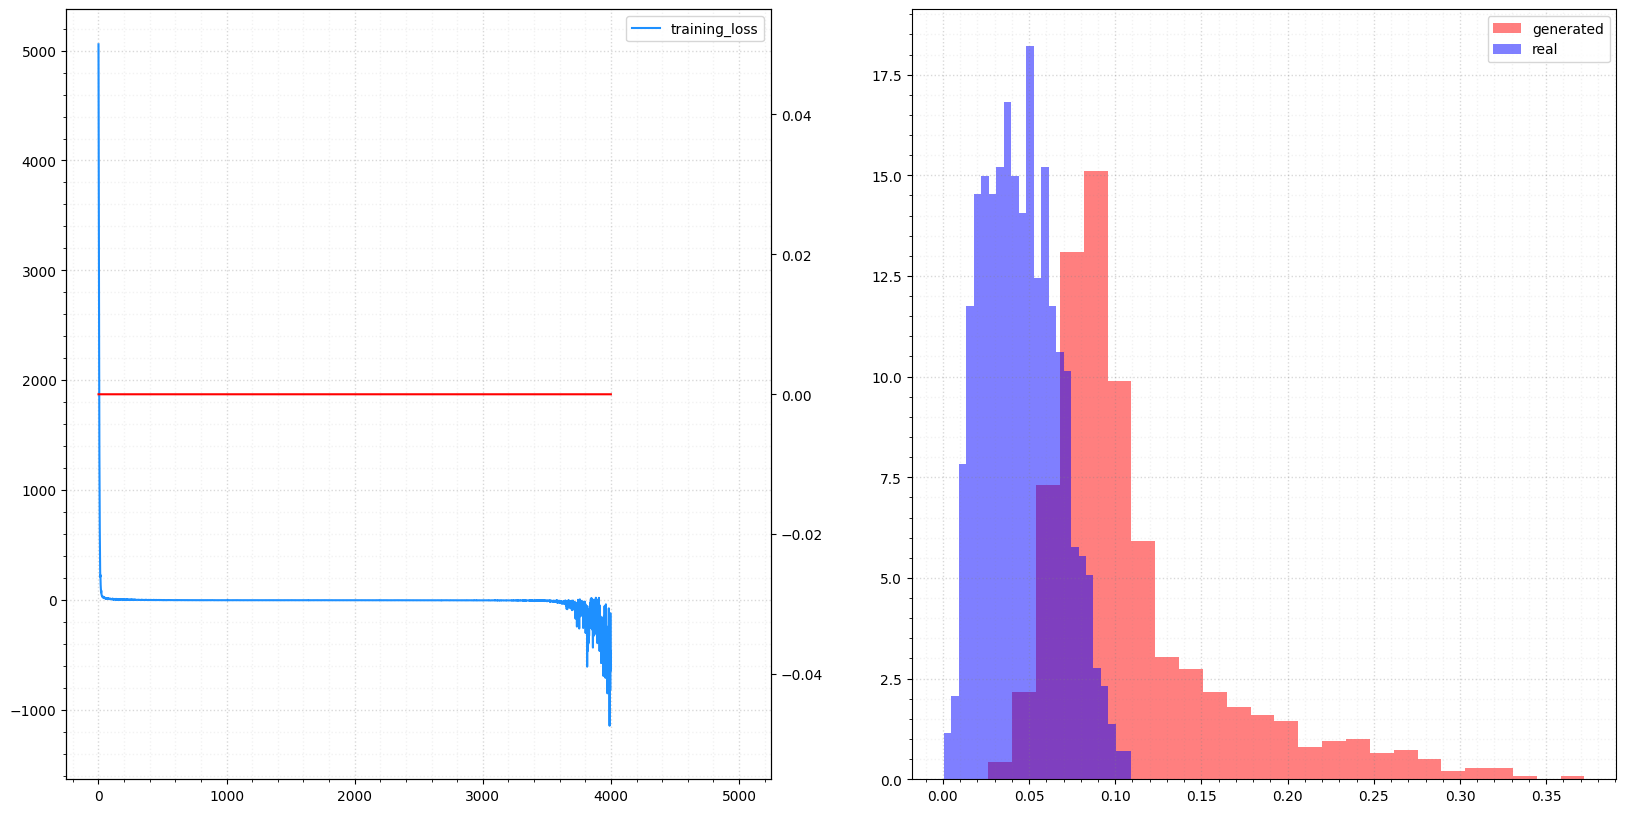

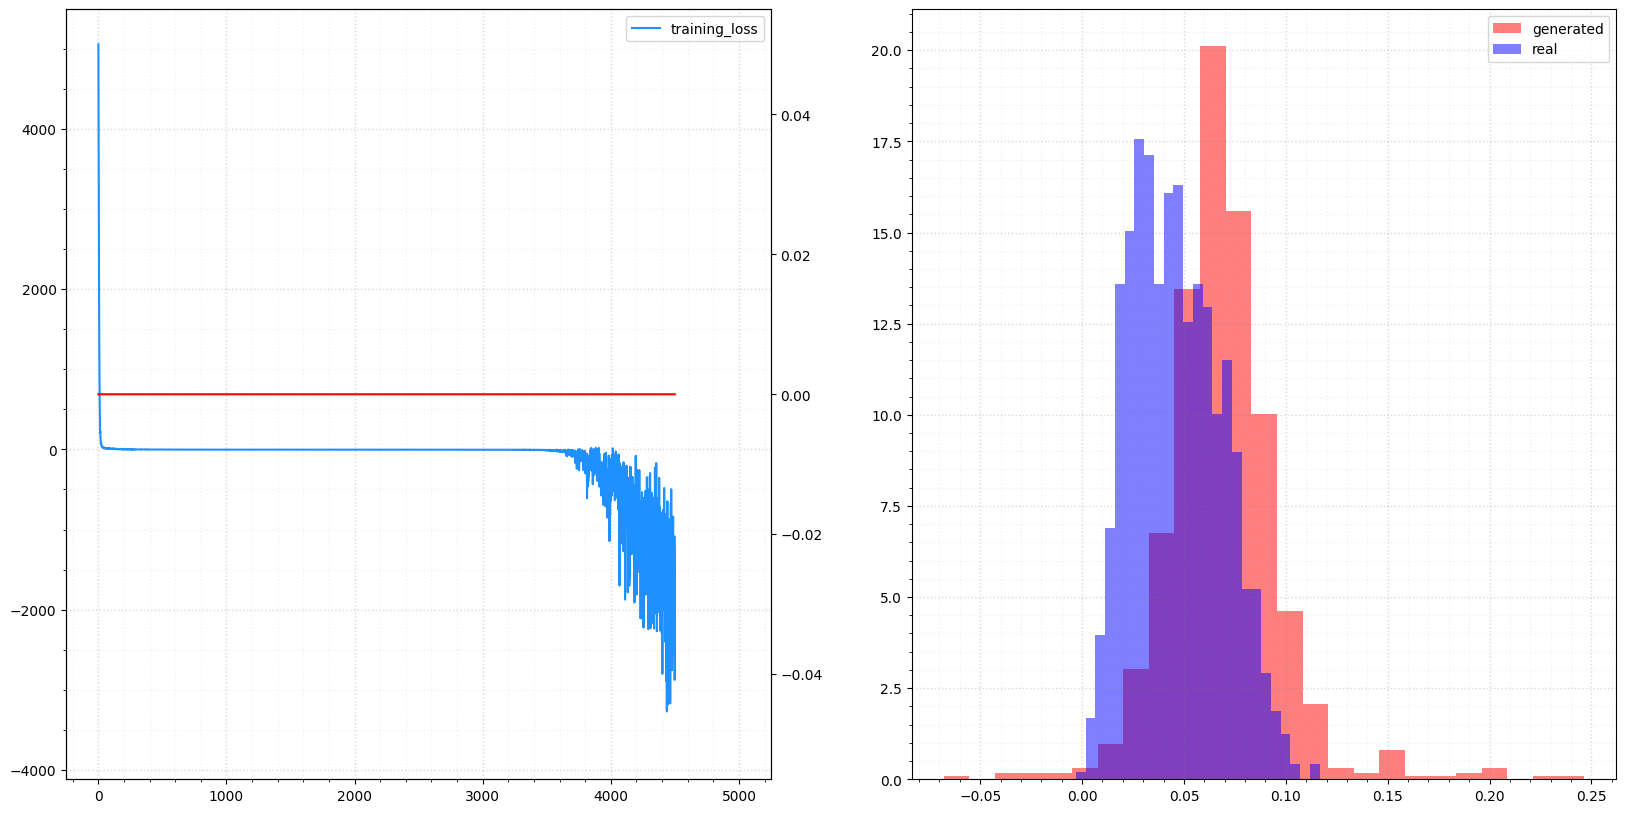

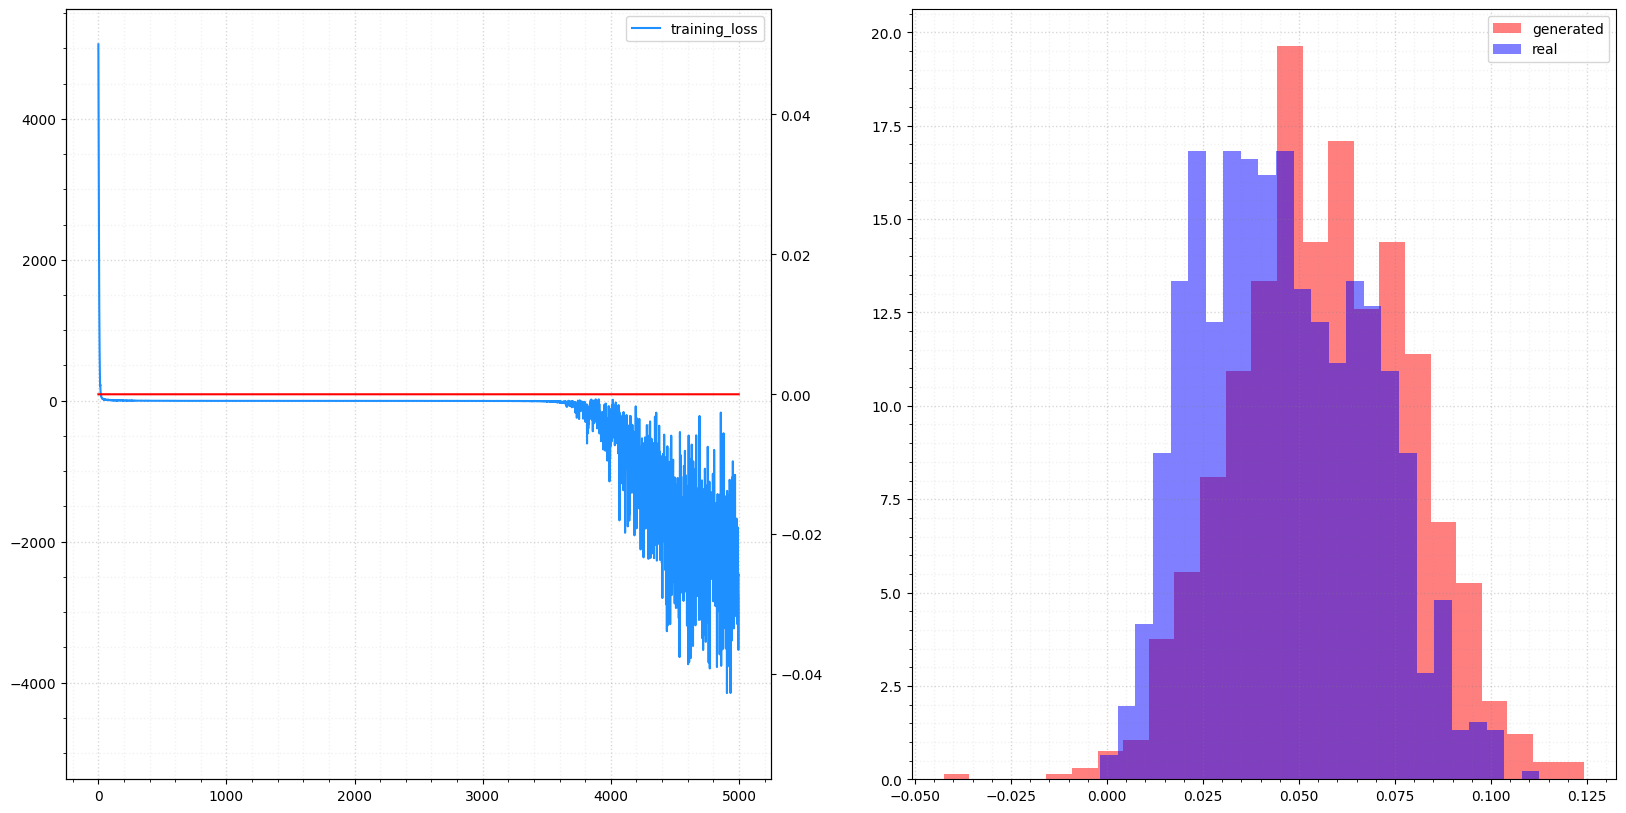

In [207]:
alpha = 1e-1
tr_loss = torch.zeros(steps, requires_grad=False).to(device)
sigmas = torch.zeros(steps, requires_grad=False).to(device)
step_vec = np.arange(steps)
trange = tqdm(range(steps), position=0, leave=True)

scheduler = ReduceLROnPlateau(generator_optimiser, mode='min', factor=0.9, patience=int(steps/10), verbose=True)
plot_data = transformed_data if do_box_cox else data.cpu().numpy()

for step in trange:
    loss = 0
    for _ in range(loss_evals):
        real_samples = next(infinite_train_dataloader)
        
        if real_samples.shape[0] != batch_size:
            real_samples = next(infinite_train_dataloader)
        
        real_samples = real_samples.to(device)
        u0 = real_samples[:, 0, :].permute(0, 2, 1).float()
        
        generated_samples = generator(grid, batch_size, u0)
        X = alpha*torch.cumsum(generated_samples, dim=1).to(torch.float32)
        Y = alpha*torch.cumsum(real_samples, dim=1).detach().to(torch.float32)
        # X =  generated_samples
        # Y = real_samples
        loss += discriminator(X, Y)

    loss /= loss_evals
    loss.backward()

    tr_loss[step] = loss.clone()

    generator_optimiser.step()
    generator_optimiser.zero_grad()
    
    scheduler.step(loss)  # should be validation loss
    
    if ((step % update_freq == 0) or (step == steps-1)):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        ax1_ = ax1.twinx() 
        # Plot updated loss
        with torch.no_grad():
            np_tr_loss = tr_loss.detach().cpu().numpy()
            np_tr_sigma = sigmas.detach().cpu().numpy()

        current_loss = np_tr_loss[:step]
        current_sigma = np_tr_sigma[:step]
        # print(current_loss)
        future_loss  = 0. if len(current_loss) == 0 else np.min(current_loss) - np.std(current_loss)
        future_sigma  = 0. if len(current_sigma) == 0 else np.min(current_sigma) - np.std(current_sigma)
        current_steps = step_vec[:step]
        current_sigmas = step_vec[:step]
        future_steps  = step_vec[step:]
        future_loss   = np.array([future_loss for _ in range(future_steps.shape[0])])
        future_sigma   = np.array([future_sigma for _ in range(future_steps.shape[0])])

        ax1.plot(current_steps, current_loss, alpha=1., color="dodgerblue", label="training_loss")
        ax1.plot(future_steps, future_loss, alpha=0.)
        ax1_.plot(current_steps, current_sigma, alpha=1., color="red", label="sigma")
        ax1_.plot(future_steps, future_sigma, alpha=0.)

        ax1.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
        ax1.minorticks_on()
        ax1.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
        
        ax1.legend()
        
        with torch.no_grad():
            to_plot = np.sort(np.random.choice(plot_data.shape[0], size=1000, replace=False))
            u0 = torch.from_numpy(plot_data[to_plot, 0, :]).to(device).permute(0,2,1).float()
            t_real = torch.from_numpy(plot_data)
            generated = generator(grid, 1000, u0)
            p = stopping_criterion(generated[:500,...,0], t_real[to_plot][:500,...,0], cutoff=1., tol=0.05)

        ax2.hist(generated.cpu().detach().numpy()[:,5,5,0], color='red', alpha=0.5,bins=25, density=True, label="generated")
        ax2.hist(plot_data[to_plot,5,5,0], color='blue', alpha=0.5, bins=25, density=True, label="real")

        ax2.grid(visible=True, color='grey', linestyle=':', linewidth=1.0, alpha=0.3)
        ax2.minorticks_on()
        ax2.grid(visible=True, which='minor', color='grey', linestyle=':', linewidth=1.0, alpha=0.1)
        
        ax2.legend(fontsize="medium")
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if (step % steps_per_print) == 0 or step == steps - 1:

        trange.write(f"Step: {step:3} Total loss (unaveraged): {loss.item():.5e} K-S passed: {100*p:.4}%")

# ###############################################################################
# ## 5. Training complete
# ################################b###############################################
# torch.save(generator.state_dict(), get_project_root().as_posix() + "/notebooks/models/generator.pkl")
# torch.save(discriminator.state_dict(), get_project_root().as_posix() + "/notebooks/models/discriminator.pkl")

## 4. Plot results

In [208]:
from mpl_toolkits.mplot3d import Axes3D


def plot_time_evolved_surface(x, y, Z, times, elev=30, azim=45):
    X, Y = np.meshgrid(x, y)

    fig = plt.figure(figsize=(14, 6))

    for i, time in enumerate(times):        
        ax = fig.add_subplot(1, len(times), i+1, projection='3d')
        ax.view_init(elev=elev, azim=azim)
        ax.plot_surface(X, Y, Z[i], cmap='viridis')
        ax.set_title(f'Time = {time:.4f}')
        ax.set_xlabel('$\log{K/S_0}$')
        ax.set_ylabel('$T$')
        ax.set_zlabel('$\sigma_I$')
    
    plt.tight_layout()
    plt.show()
    
    
def plot_time_evolved_slice(x, y, Z, time, ax=None):
    X, Y = np.meshgrid(x, y)
    
    if ax is None:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111, projection='3d')
        
    ax.plot_surface(X, Y, Z, cmap='coolwarm')
    ax.set_title(f'Surface slice, strike = {time:.4f}')
    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel('$t$')
    ax.set_zlabel('$\sigma_I$')
    plt.tight_layout()
    plt.show()

In [209]:
real_samples = next(infinite_train_dataloader)
u0 = real_samples[:, 0, :].permute(0, 2, 1).float()

with torch.no_grad():
    if method == "slice":
        generated_samples = generator(grid, batch_size, u0).cpu().numpy()
        
        if do_box_cox:
            generated_plot_samples = apply_inverse_boxcox(generated_samples, lambdas, adj)
            real_plot_samples = apply_inverse_boxcox(real_samples.cpu().numpy(), lambdas, adj)
        else:
            generated_plot_samples = generated_samples
            real_plot_samples = real_samples.cpu().numpy()
    else:
        generated_plot_samples = generator(grid, batch_size, u0).reshape((batch_size, t, T, K)).cpu().numpy()
        real_plot_samples = real_samples.reshape((batch_size, t, T, K)).cpu().numpy()

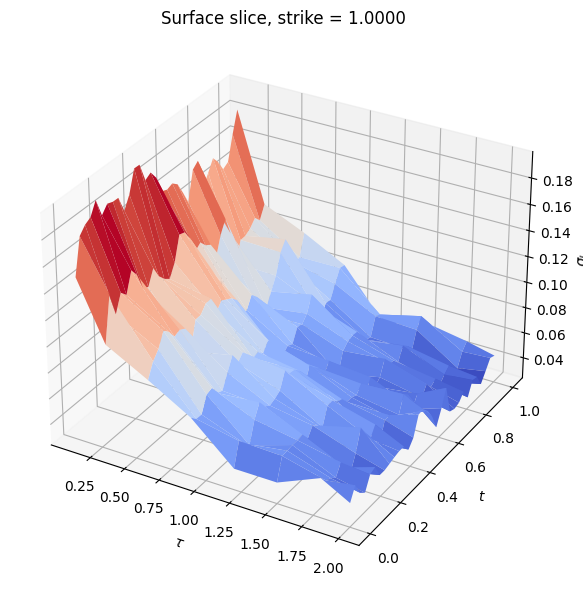

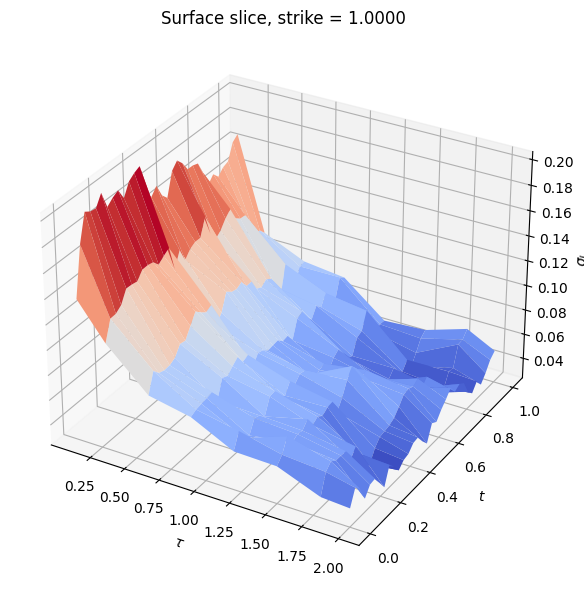

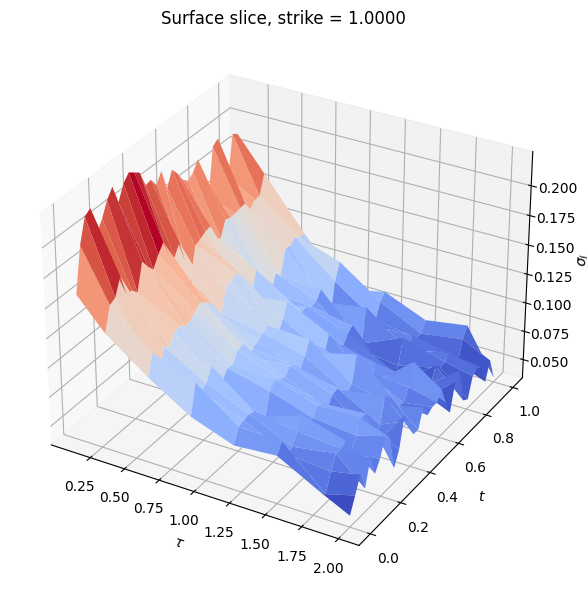

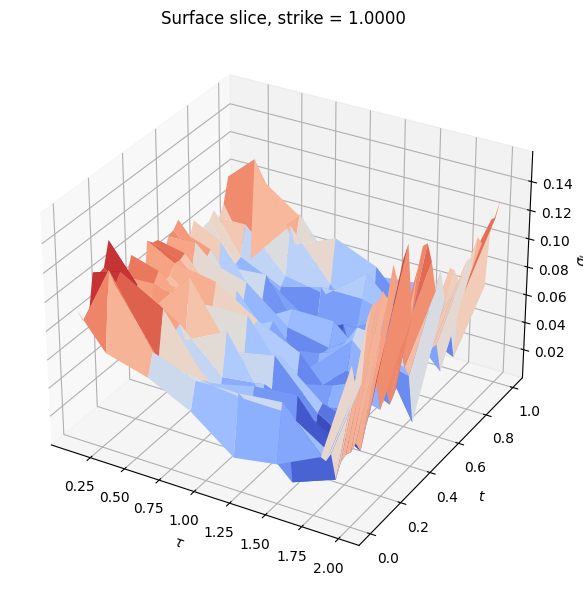

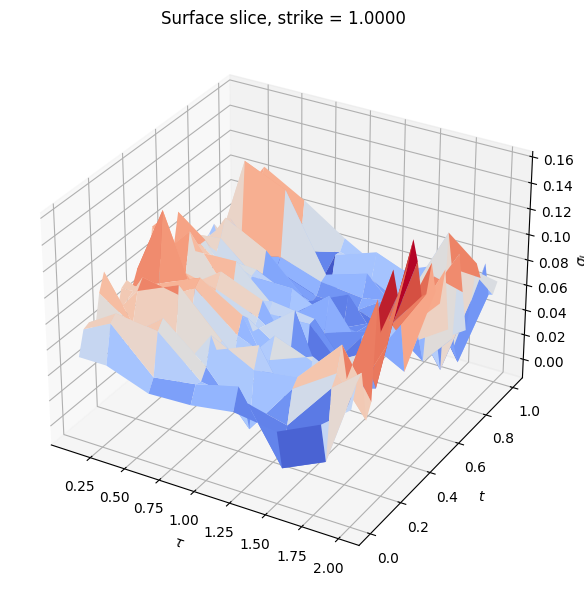

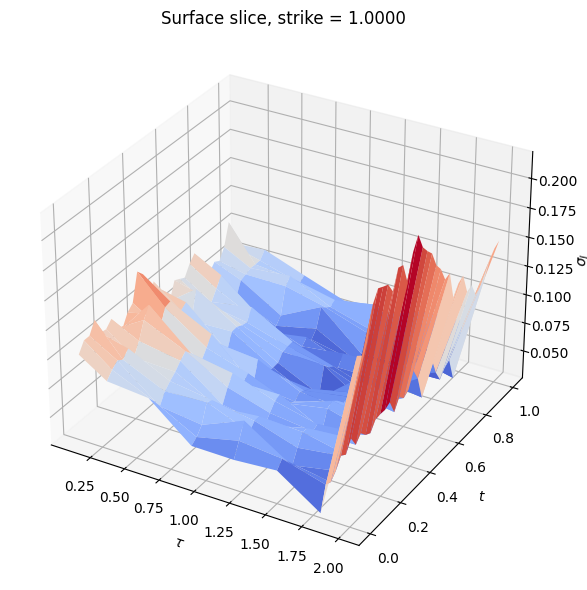

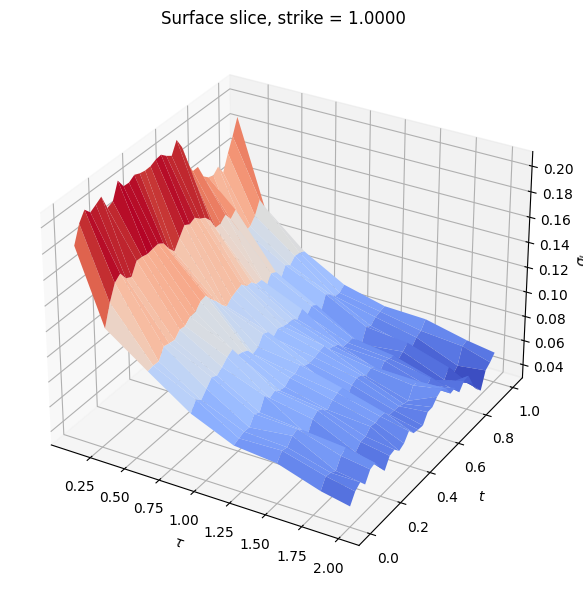

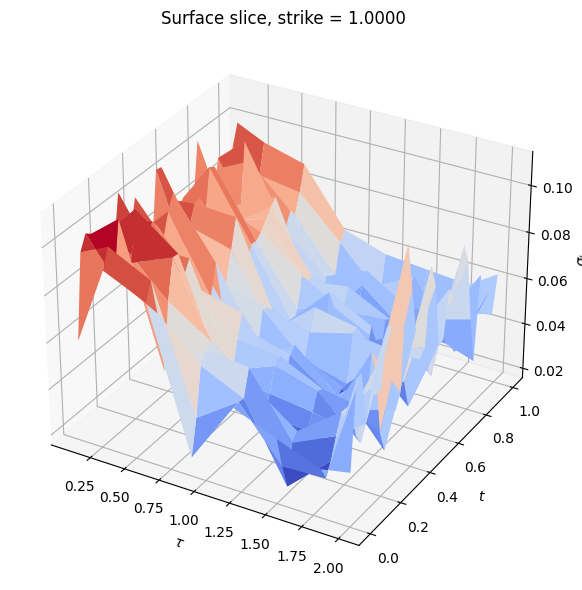

In [210]:
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])
maturities = np.array([0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0])
plot_ts = np.linspace(0, 1, dim_t)

if method == "slice":
    for i in range(8):
        plot_time_evolved_slice(maturities, plot_ts, generated_plot_samples[i,..., 0], strikes[5])
elif method == "stack":
    x = strikes[K_cut:-K_cut]
    y = maturities[T_cut:-T_cut]
    plot_time_evolved_surface(x, y, generated_plot_samples[0, ::8], times[::8])

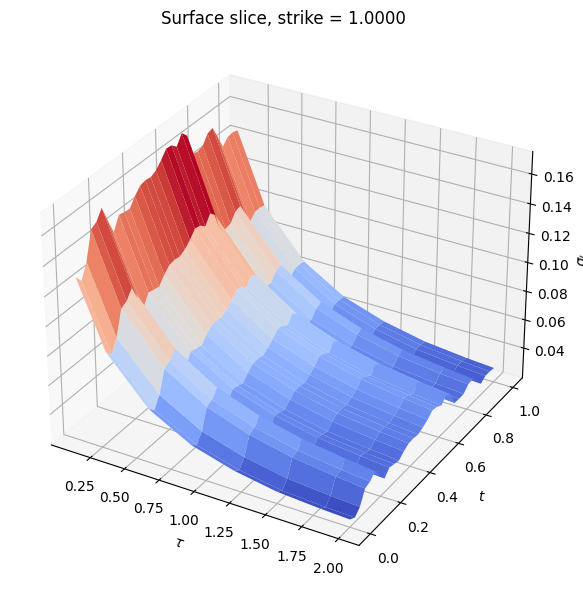

In [211]:
if method == "slice":
    plot_time_evolved_slice(maturities, plot_ts, real_plot_samples[0,..., 0], strikes[5])
elif method == "stack":
    plot_time_evolved_surface(x, y, real_plot_samples[0, ::8], times[::8])

### Smooth results

In [212]:
from scipy.interpolate import UnivariateSpline

def apply_univariate_spline_smoothing(tensor, axis, s=0):
    """
    Apply Univariate Spline smoothing to a PyTorch tensor along a specified axis.
    's' is the smoothing factor; higher 's' means more smoothing.
    """
    # Convert the tensor to a NumPy array
    tensor_np = tensor.numpy()
    
    # Define a function to apply spline smoothing to an array
    def smooth_array(arr):
        x = np.arange(arr.size)
        spline = UnivariateSpline(x, arr, s=s)
        return spline(x)
    
    # Apply the smoothing function along the specified axis
    smoothed_np = np.apply_along_axis(smooth_array, axis=axis, arr=tensor_np)
    
    # Convert the smoothed data back to a PyTorch tensor
    smoothed_tensor = torch.from_numpy(smoothed_np).to(tensor.dtype)
    
    return smoothed_tensor

In [213]:
generated_samples.shape

(64, 32, 8, 1)

In [214]:
s1 = 1e-4
s2 = 1e2

generated_samples_ = torch.tensor(generated_samples)
res = apply_univariate_spline_smoothing(
    apply_univariate_spline_smoothing(generated_samples_, 1, s1),
    2, s2
)

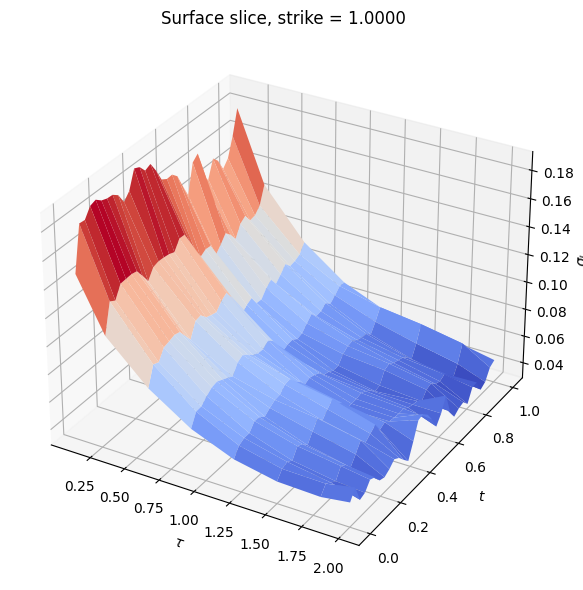

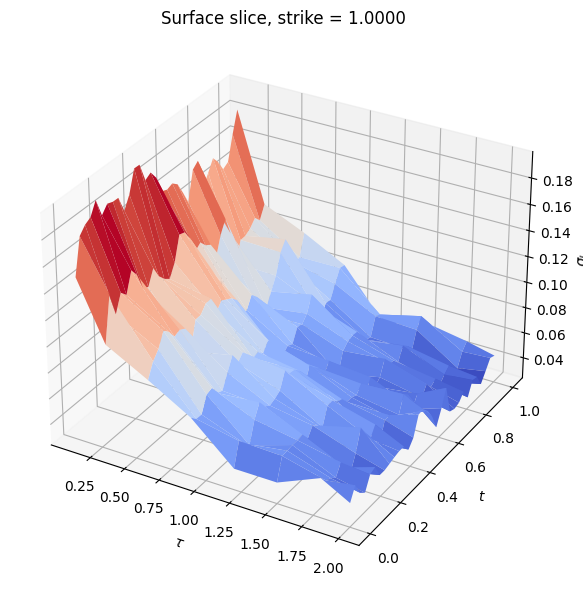

In [215]:
plot_time_evolved_slice(maturities, plot_ts, res[0, ..., 0], strikes[5])
plot_time_evolved_slice(maturities, plot_ts, generated_samples[0, ..., 0], strikes[5])